In [2]:
import itertools
from pathlib import Path
import re

import matplotlib.animation as anim
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import scipy.stats as st
import seaborn as sns

In [3]:
sns.set_context("talk", font_scale=1.5)

In [4]:
cd ..

/userdata/jgauthier/projects/ideal-word-representations


In [5]:
study_models = {
    "Word": "librispeech-train-clean-100/w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames",
    "Word fixed": "librispeech-train-clean-100/w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames_fixedlen25",
    "Random": "librispeech-train-clean-100/w2v2_8/randomrnn_32/random",
    "Phoneme": "librispeech-train-clean-100/w2v2_8/rnn_8-weightdecay0.01/phoneme_10frames",
}
study_model_rev = {v: k for k, v in study_models.items()}

In [6]:
# frames = {}
# for study_model in study_models:
#     frames_i = list(Path(f"outputs/notebooks/{study_model}/rsa_phoneme/").glob("rsa-position-*.png"))
#     frames_i = {int(re.search(r"(\d+).png", str(f)).group(1)): f for f in frames_i}
#     frames[study_model] = frames_i

In [7]:
# f, axs = plt.subplots(1, len(frames), figsize=(8 * len(frames), 8))
# # reduce spacing
# plt.subplots_adjust(wspace=-0.25, hspace=0)
# for study_model, ax in zip(frames, axs.flat):
#     ax.axis("off")
#     ax.set_title(study_model, fontsize=8)

# def animate(i):
#     for study_model, ax in zip(frames, axs.flat):
#         im = plt.imread(frames[study_model][i])
#         ax.imshow(im)

# num_frames = len(frames[study_models[0]])
# ani = anim.FuncAnimation(f, animate, frames=num_frames, interval=100)
# ani.save("summary_notebooks/rsa_phoneme.gif", writer="imagemagick", fps=2)

## Quantitative comparison of RSA matrices

In [8]:
rsa_mats = {}
rsa_mats_tril = {}
rsa_groupers = [["position", 1], ["position_within_frequency", 2],
                ["position_within_length", 2], ["relative_position", 1]]
rsa_path_template = "outputs/notebooks/{}/rsa_phoneme/rsa_results-{}.csv"
# get a global order over phonemes in all the CSVs
phoneme_order = sorted(set(itertools.chain.from_iterable([pd.read_csv(rsa_path_template.format(study_model, grouper),
    index_col=list(range(grouper_num_levels)) + [grouper_num_levels]).index.get_level_values(-1)
 for study_model in study_models.values()
 for grouper, grouper_num_levels in rsa_groupers])))
print(" ".join(phoneme_order))

# keep track of phoneme*group-value combinations which are unattested
unattested_phoneme_frames = {}

for study_model in study_models.values():
    for grouper, grouper_num_levels in rsa_groupers:
        rsa_i = pd.read_csv(rsa_path_template.format(study_model, grouper), index_col=list(range(grouper_num_levels)) + [grouper_num_levels])
        for grouping_value, rsa_ij in rsa_i.groupby(rsa_i.index.names[:-1]):
            # reindex to make sure we have all phonemes here
            # for some reason reindexing on the lower multiindex levels doesn't work
            # so we'll do a unstack+stack trick
            grouper_levels = rsa_ij.index.names[:grouper_num_levels]
            rsa_ij = rsa_ij.unstack(grouper_levels) \
                .reindex(index=phoneme_order, fill_value=np.nan) \
                .stack(grouper_levels, future_stack=True) \
                .reorder_levels(grouper_levels + [rsa_ij.index.names[-1]])
            assert (rsa_ij.index.get_level_values(-1) == phoneme_order).all()
            rsa_mats[study_model, grouper, grouping_value] = rsa_ij.values

            # find columns which are wholly unattested
            unattested_ij = set(np.isclose(rsa_ij.values, 0).all(axis=0).nonzero()[0]) | \
                set(np.isnan(rsa_ij.values).all(axis=0).nonzero()[0])
            if (grouper, grouping_value) not in unattested_phoneme_frames:
                unattested_phoneme_frames[grouper, grouping_value] = unattested_ij
            else:
                unattested_phoneme_frames[grouper, grouping_value] &= unattested_ij

            # rsa_mats_tril[study_model, frame_idx] = rsa_ij.values[np.tril_indices(len(phoneme_order))]

AA AE AH AO AW AY B CH D DH EH ER EY F G HH IH IY JH K L M N NG OW OY P R S SH T TH UH UW V W Y Z ZH


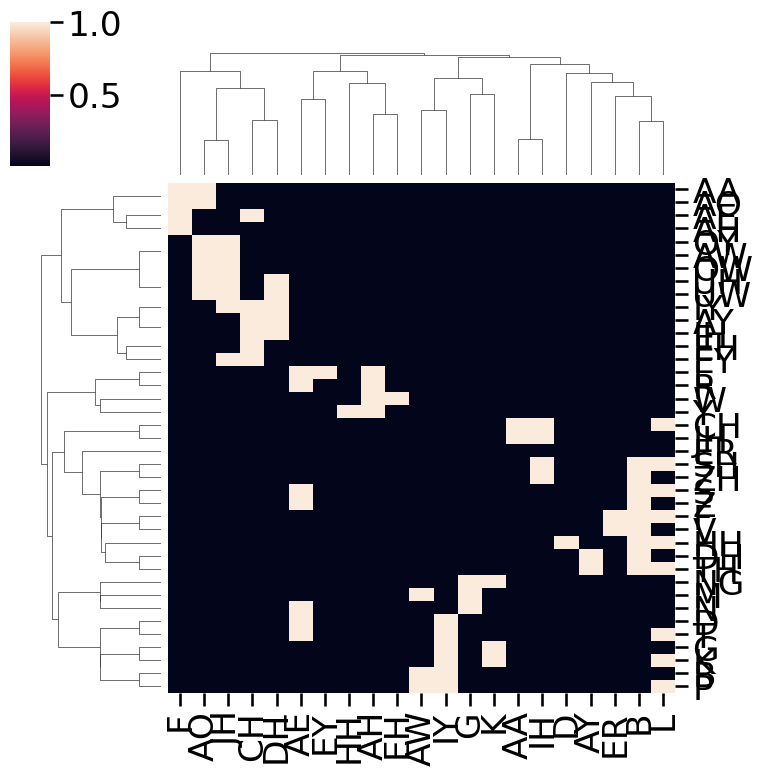

In [9]:
# Define features for each phoneme
cmudict_features = {
    "AA": "low back",
    "AE": "low front",
    "AH": "low",
    "AO": "low back",
    "AW": "back rounded",
    "AY": "high front",
    "B": "bilabial plosive",
    "CH": "voiceless palato-alveolar affricate",
    "D": "alveolar plosive",
    "DH": "dental fricative",
    "EH": "front",
    "ER": "",
    "EY": "front rounded",
    "F": "voiceless labiodental fricative",
    "G": "velar plosive",
    "HH": "voiceless glottal fricative",
    "IH": "high front",
    "IY": "high front rounded",
    "JH": "palato-alveolar affricate",
    "K": "voiceless velar plosive",
    "L": "alveolar lateral approximant",
    "M": "bilabial nasal",
    "N": "alveolar nasal",
    "NG": "velar nasal",
    "OW": "back rounded",
    "OY": "back rounded",
    "P": "voiceless bilabial plosive",
    "R": "alveolar approximant",
    "S": "voiceless alveolar fricative",
    "SH": "voiceless palato-alveolar fricative",
    "T": "voiceless alveolar plosive",
    "TH": "voiceless dental fricative",
    "UH": "high back rounded",
    "UW": "high back rounded",
    "V": "labiodental fricative",
    "W": "labio-velar approximant",
    "Y": "palatal approximant",
    "Z": "alveolar fricative",
    "ZH": "palato-alveolar fricative",
}
cmudict_features = {k: v.split() for k, v in cmudict_features.items()}
assert set(cmudict_features.keys()) == set(phoneme_order)
all_features = sorted(set([f for v in cmudict_features.values() for f in v]))
feature_matrix = np.zeros((len(cmudict_features), len(all_features)), dtype=int) + 0.001
for i, (phoneme, features) in enumerate(cmudict_features.items()):
    for feature in features:
        j = all_features.index(feature)
        feature_matrix[i, j] = 1

# Convert to a DataFrame
feature_matrix = pd.DataFrame(feature_matrix, index=phoneme_order, columns=all_features)
distance_matrix = squareform(pdist(feature_matrix, metric="cosine"))
static_distances = {"featural": distance_matrix}

sns.clustermap(feature_matrix, yticklabels=phoneme_order, xticklabels=phoneme_order, metric="cosine", figsize=(8, 8))

In [10]:
grouping_values = sorted(set((grouper, grouping_value)
                              for _, grouper, grouping_value in rsa_mats))

# create a mask to extract lower triangle of RSA matrices (including diagonal),
# excluding phonemes which are unattested
tril_masks = {}
for grouper, grouping_value in grouping_values:
    mask = np.zeros((len(phoneme_order), len(phoneme_order)), dtype=bool)
    mask[np.tril_indices(len(phoneme_order))] = True
    mask[list(unattested_phoneme_frames[grouper, grouping_value]), :] = False
    mask[:, list(unattested_phoneme_frames[grouper, grouping_value])] = False
    tril_masks[grouper, grouping_value] = mask

# store extracted subsets of lower triangle
rsa_mats_tril = {(study_model, grouper, grouping_value): rsa_mat[tril_masks[grouper, grouping_value]]
                 for (study_model, grouper, grouping_value), rsa_mat in rsa_mats.items()}

In [11]:
# stack within frame
rsa_mats_tril_stacked = {
    (grouper, grouping_value): np.stack([rsa_mats_tril[study_model, grouper, grouping_value]
                         for study_model in study_models.values()])
    for grouper, grouping_value in grouping_values}

# drop frames with not enough phoneme pair data
rsa_mats_tril_stacked = {(grouper, grouping_value): rsa_mat
                         for (grouper, grouping_value), rsa_mat in rsa_mats_tril_stacked.items()
                         if rsa_mat.shape[1] >= (12 - 1) ** 2}

In [12]:
# add in static distance matrices
for name, sim in static_distances.items():
    for key in rsa_mats_tril_stacked:
        rsa_mats_tril_stacked[key] = np.concatenate([
            rsa_mats_tril_stacked[key], sim[tril_masks[key]][None, :]])

all_models = list(study_models.values()) + list(static_distances.keys())

In [13]:
reference_model = "featural"
reference_model = all_models[2]
reference_model_idx = all_models.index(reference_model)
reference_model

'librispeech-train-clean-100/w2v2_8/randomrnn_32/random'

In [14]:
all_models

['librispeech-train-clean-100/w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames',
 'librispeech-train-clean-100/w2v2_8/rnn_32-hinge-mAP4/word_broad_10frames_fixedlen25',
 'librispeech-train-clean-100/w2v2_8/randomrnn_32/random',
 'librispeech-train-clean-100/w2v2_8/rnn_8-weightdecay0.01/phoneme_10frames',
 'featural']

In [15]:
rsa_sims = {
    (grouper, grouping_value): [
        st.spearmanr(tril_stacked_i[model_idx],
                     tril_stacked_i[reference_model_idx])[0]
        for model_idx, _ in enumerate(all_models)]
    for (grouper, grouping_value), tril_stacked_i in rsa_mats_tril_stacked.items()
}

In [16]:
rsa_sims_df = pd.DataFrame(rsa_sims, index=all_models).reset_index().melt(id_vars=[("index", "")])
rsa_sims_df.columns = ["index", "grouper", "grouping_value", "similarity"]
rsa_sims_df["Trace"] = rsa_sims_df["index"].map({"featural": "Featural", **{v: k for k, v in study_models.items()}})
rsa_sims_df = rsa_sims_df.set_index(["grouper", "index", "grouping_value"]).sort_index()
rsa_sims_df["similarity_delta"] = rsa_sims_df["similarity"] - rsa_sims_df.groupby(["grouper", "index"])["similarity"].head(1).droplevel(-1)
rsa_sims_df = rsa_sims_df.reset_index("grouping_value")
rsa_sims_df["grouping_value"] = rsa_sims_df.grouping_value.map(lambda x: " ".join(str(i) for i in x))

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

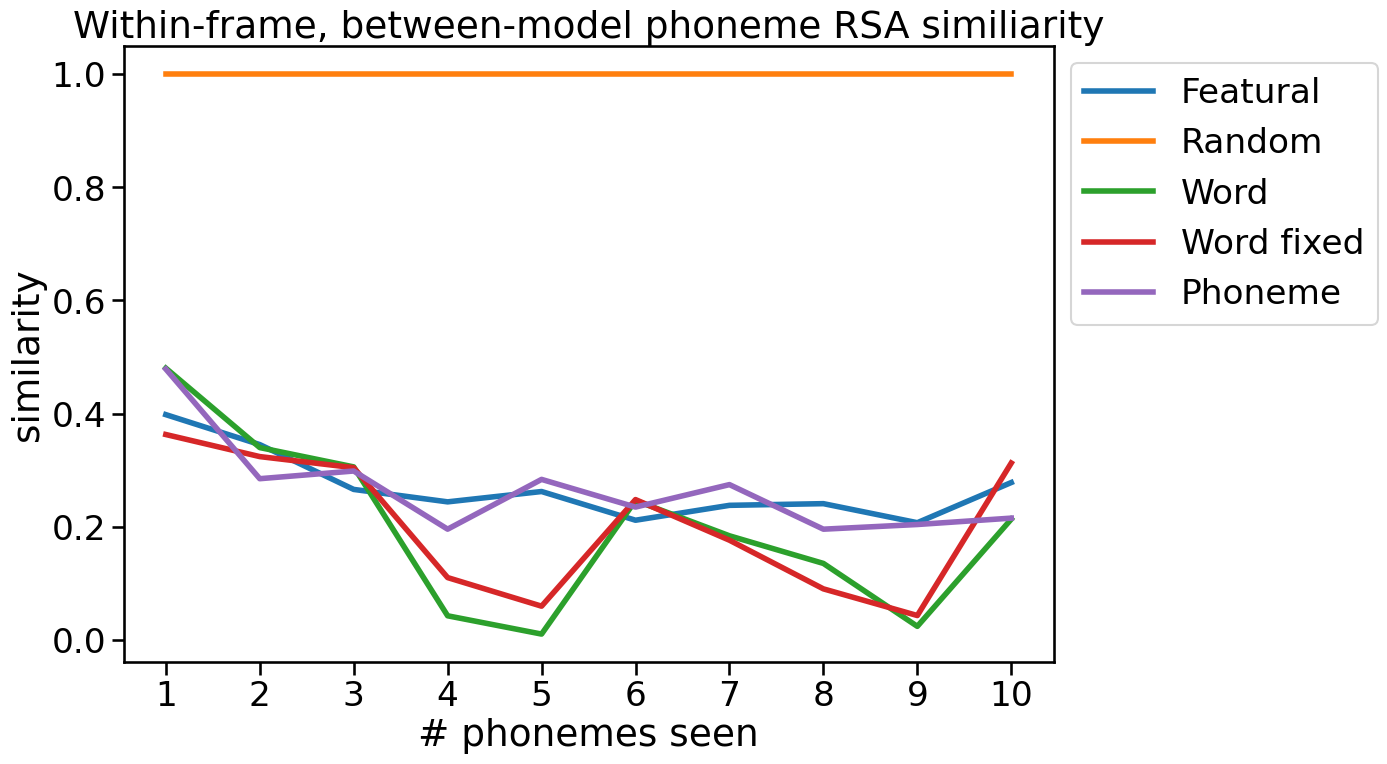

In [17]:
f, ax = plt.subplots(figsize=(12, 8))
plot_position_df = rsa_sims_df.loc["position"].reset_index() \
                    .assign(grouping_value=lambda x: x.grouping_value.astype(int) + 1)
plot_position_df = plot_position_df[plot_position_df.grouping_value <= 10]
sns.lineplot(data=plot_position_df,
             x="grouping_value", y="similarity", hue="Trace",
             ax=ax, linewidth=4)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.set_title("Within-frame, between-model phoneme RSA similiarity")
ax.set_xlabel("# phonemes seen")
ax.set_xticks(range(1, 11))

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

Text(0.5, 1.0, 'Relative word position, between-model phoneme RSA similiarity')

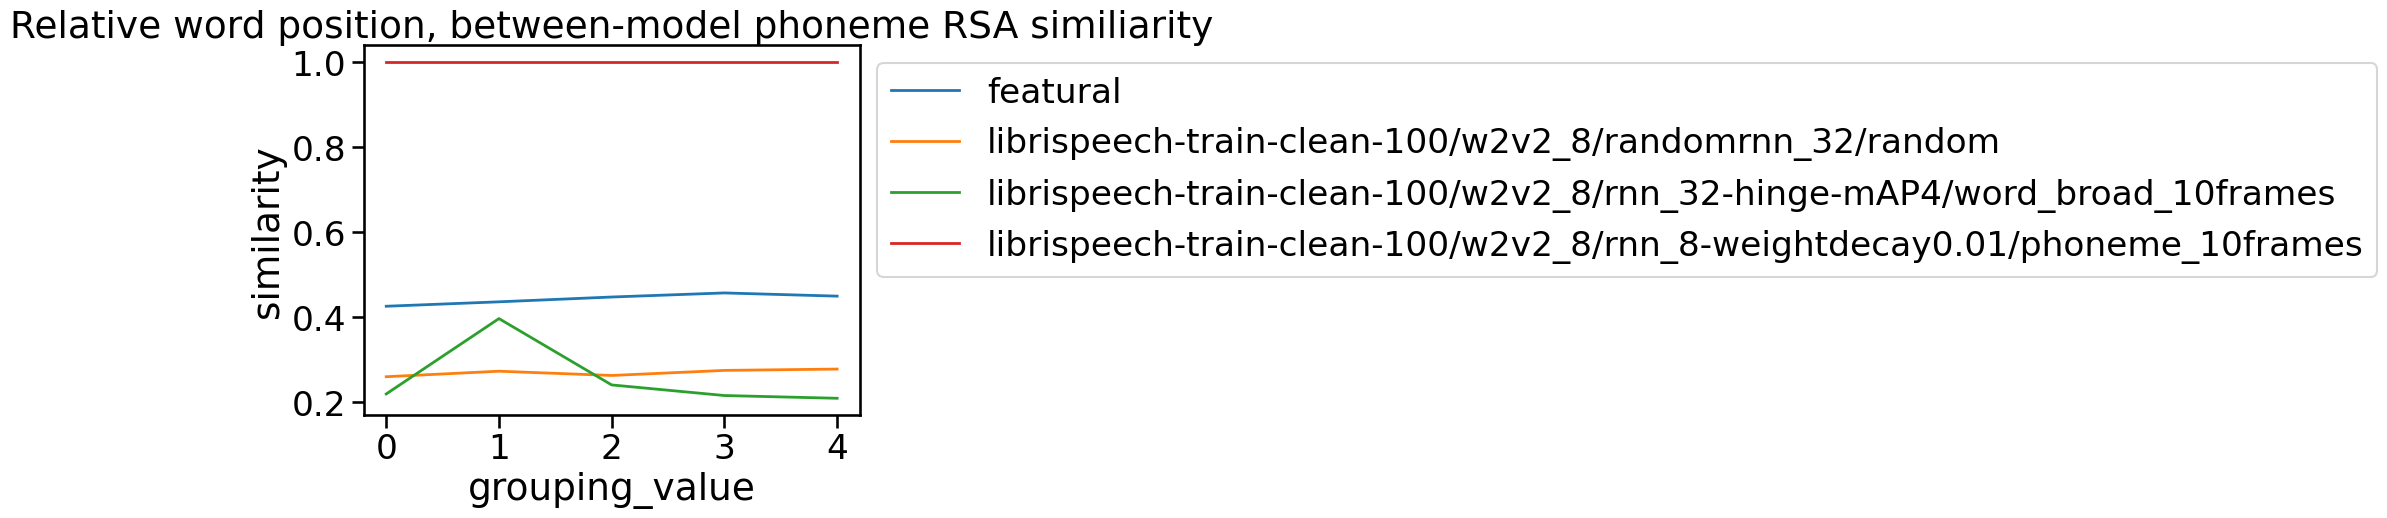

In [131]:
ax = sns.lineplot(data=rsa_sims_df.loc["relative_position"].reset_index(),
                  x="grouping_value", y="similarity", hue="index", linewidth=2)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.set_title("Relative word position, between-model phoneme RSA similiarity")

In [142]:
g.row_names

['Random', 'Word']

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

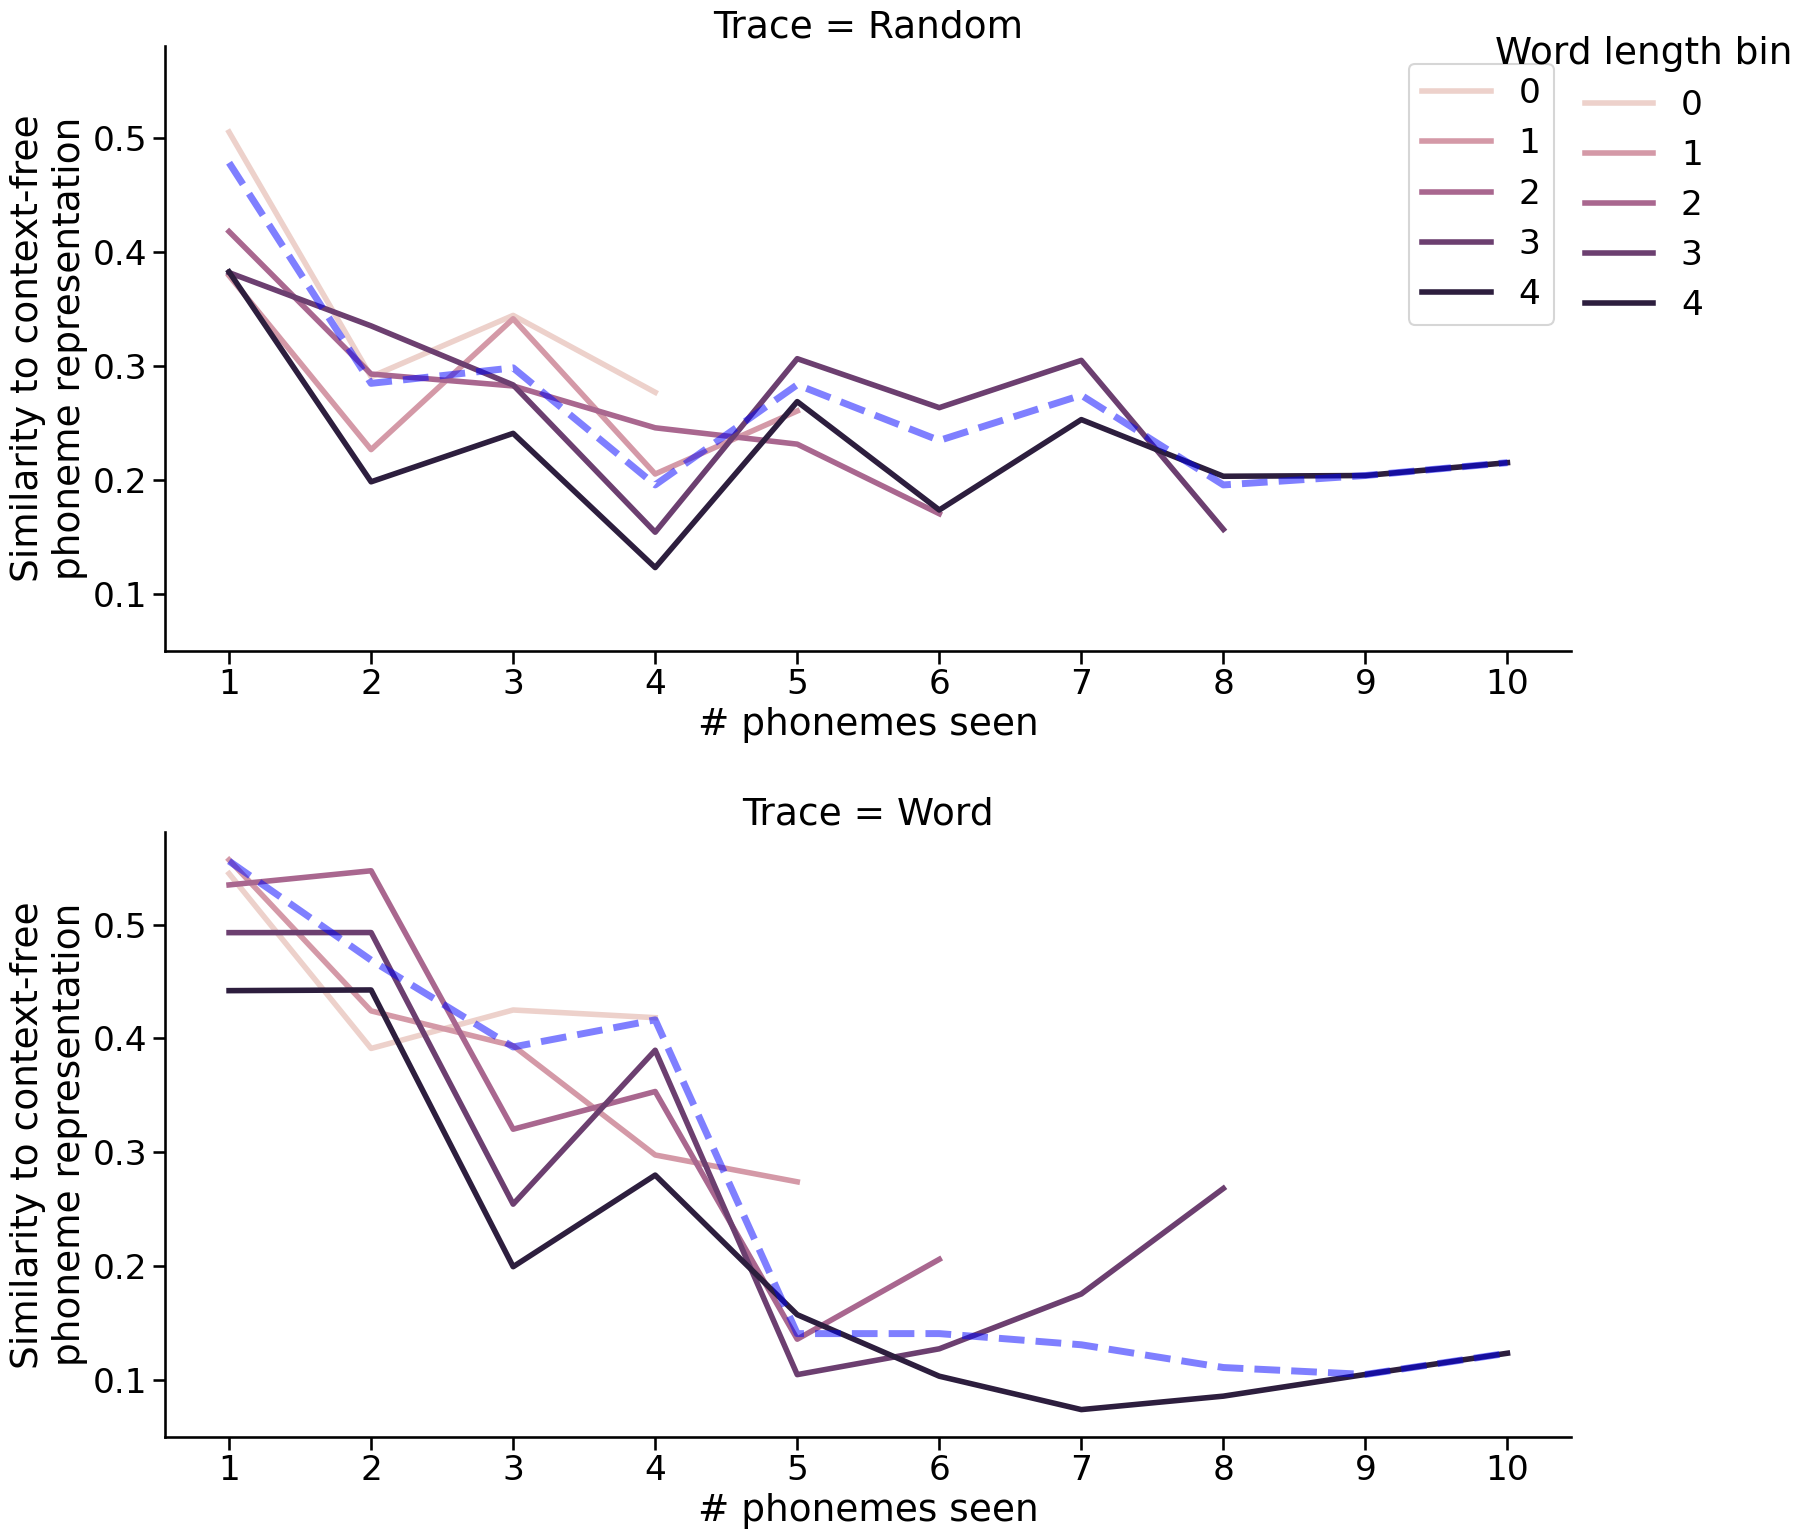

In [152]:
rsa_sims_pos_length = rsa_sims_df.loc["position_within_length"].reset_index()
# remove reference level
rsa_sims_pos_length = rsa_sims_pos_length[~rsa_sims_pos_length["index"].isin([reference_model, "featural"])]
rsa_sims_pos_length["length_bin"] = rsa_sims_pos_length.grouping_value.map(lambda x: x.split()[0]).astype(float).astype(int)
rsa_sims_pos_length["# phonemes seen"] = rsa_sims_pos_length.grouping_value.map(lambda x: x.split()[1]).astype(int) + 1
rsa_sims_pos_length = rsa_sims_pos_length[rsa_sims_pos_length["# phonemes seen"] <= 10]
g = sns.relplot(data=rsa_sims_pos_length, x="# phonemes seen", y="similarity", hue="length_bin", row="Trace",
            kind="line", height=8, aspect=2, linewidth=4, facet_kws=dict(sharex=False))

g.legend.set_title("Word length bin")
g.legend.set_bbox_to_anchor((1, 0.85))

for ax in g.axes.flat:
    ax.set_xticks(range(1, 11))
    ax.set_ylabel("Similarity to context-free\nphoneme representation")

for (i, j, k), data in g.facet_data():
    ax = g.facet_axis(i, j)
    # plot overall
    sns.lineplot(data=plot_position_df[plot_position_df.Trace == g.row_names[i]],
                 x="grouping_value", y="similarity", ax=ax, color="blue", alpha=0.5,
                 linewidth=5, linestyle="--")
    ax.set_xlabel("# phonemes seen")

# adjust hspace
g.fig.subplots_adjust(hspace=0.3)

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jgauthier/u/tran

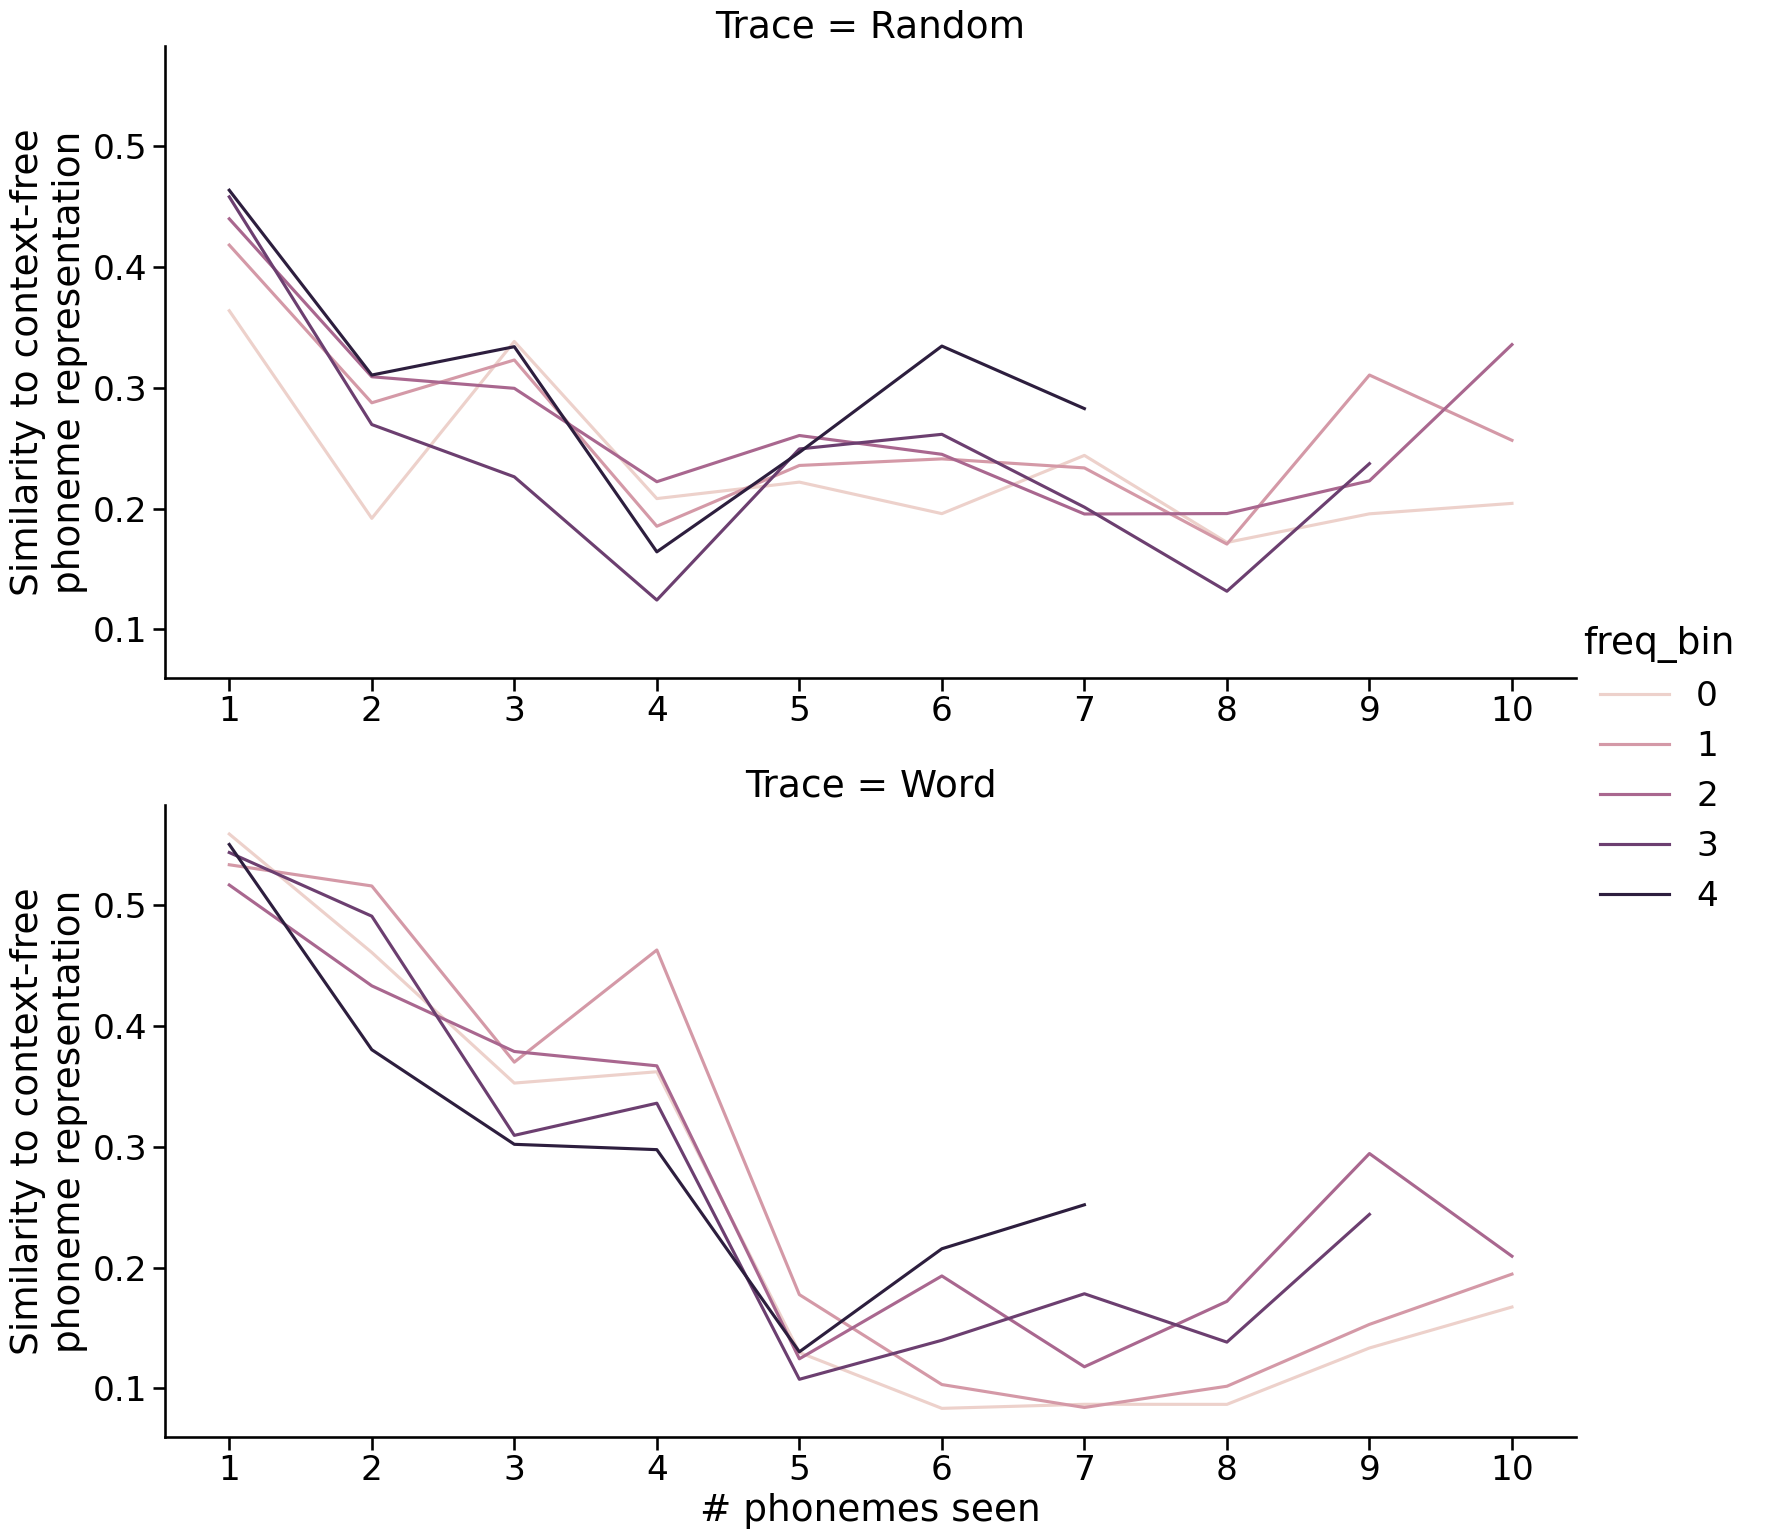

In [133]:
rsa_sims_pos_freq = rsa_sims_df.loc["position_within_frequency"].reset_index()
# remove reference level
rsa_sims_pos_freq = rsa_sims_pos_freq[~rsa_sims_pos_freq["index"].isin([reference_model, "featural"])]
rsa_sims_pos_freq["freq_bin"] = rsa_sims_pos_freq.grouping_value.map(lambda x: x.split()[0]).astype(float).astype(int)
rsa_sims_pos_freq["# phonemes seen"] = rsa_sims_pos_freq.grouping_value.map(lambda x: x.split()[1]).astype(int) + 1
rsa_sims_pos_freq = rsa_sims_pos_freq[rsa_sims_pos_freq["# phonemes seen"] <= 10]
g = sns.relplot(data=rsa_sims_pos_freq, x="# phonemes seen", y="similarity", hue="freq_bin", row="Trace",
                kind="line", height=8, aspect=2, facet_kws=dict(sharex=False))#, linewidth=2)
for ax in g.axes.flat:
    ax.set_xticks(range(1, 11))
    ax.set_ylabel("Similarity to context-free\nphoneme representation")

<Axes: >

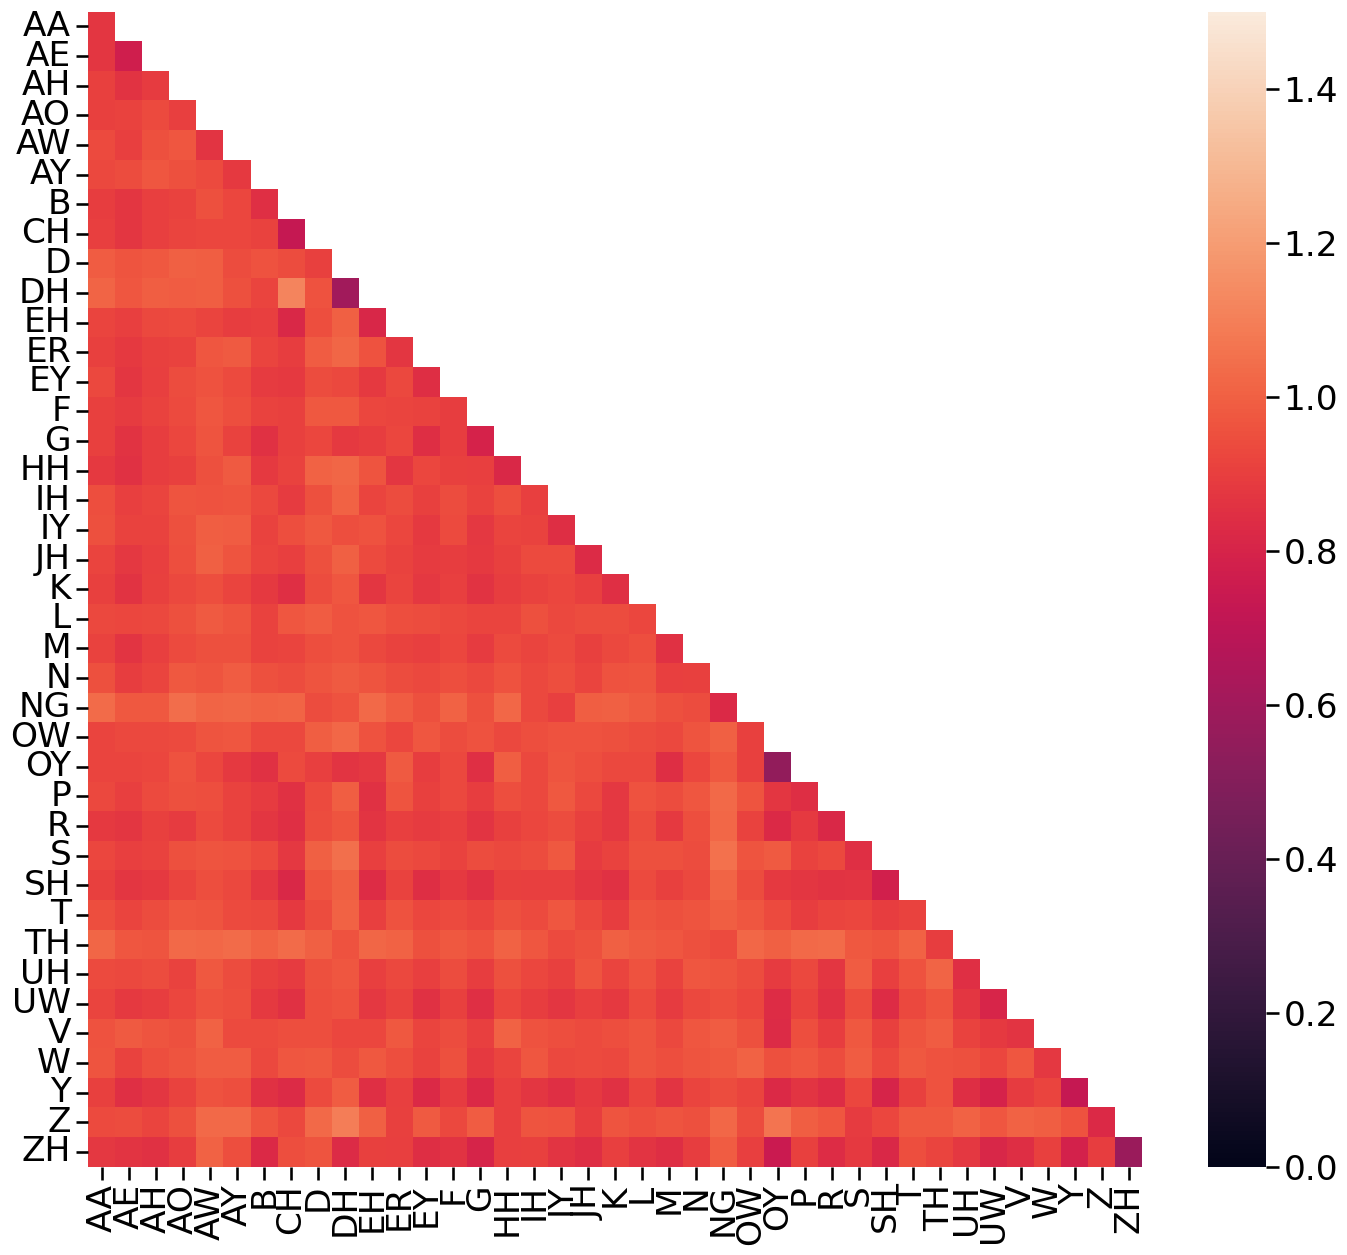

In [134]:
heatmap_model_name = "Word"
heatmap_model = study_models[heatmap_model_name]
f, ax = plt.subplots(figsize=(17, 15))
sns.heatmap(rsa_mats[heatmap_model, "position", (4,)], xticklabels=phoneme_order, yticklabels=phoneme_order, ax=ax, vmin=0, vmax=1.5)

Text(0.5, 0.98, 'Phoneme')

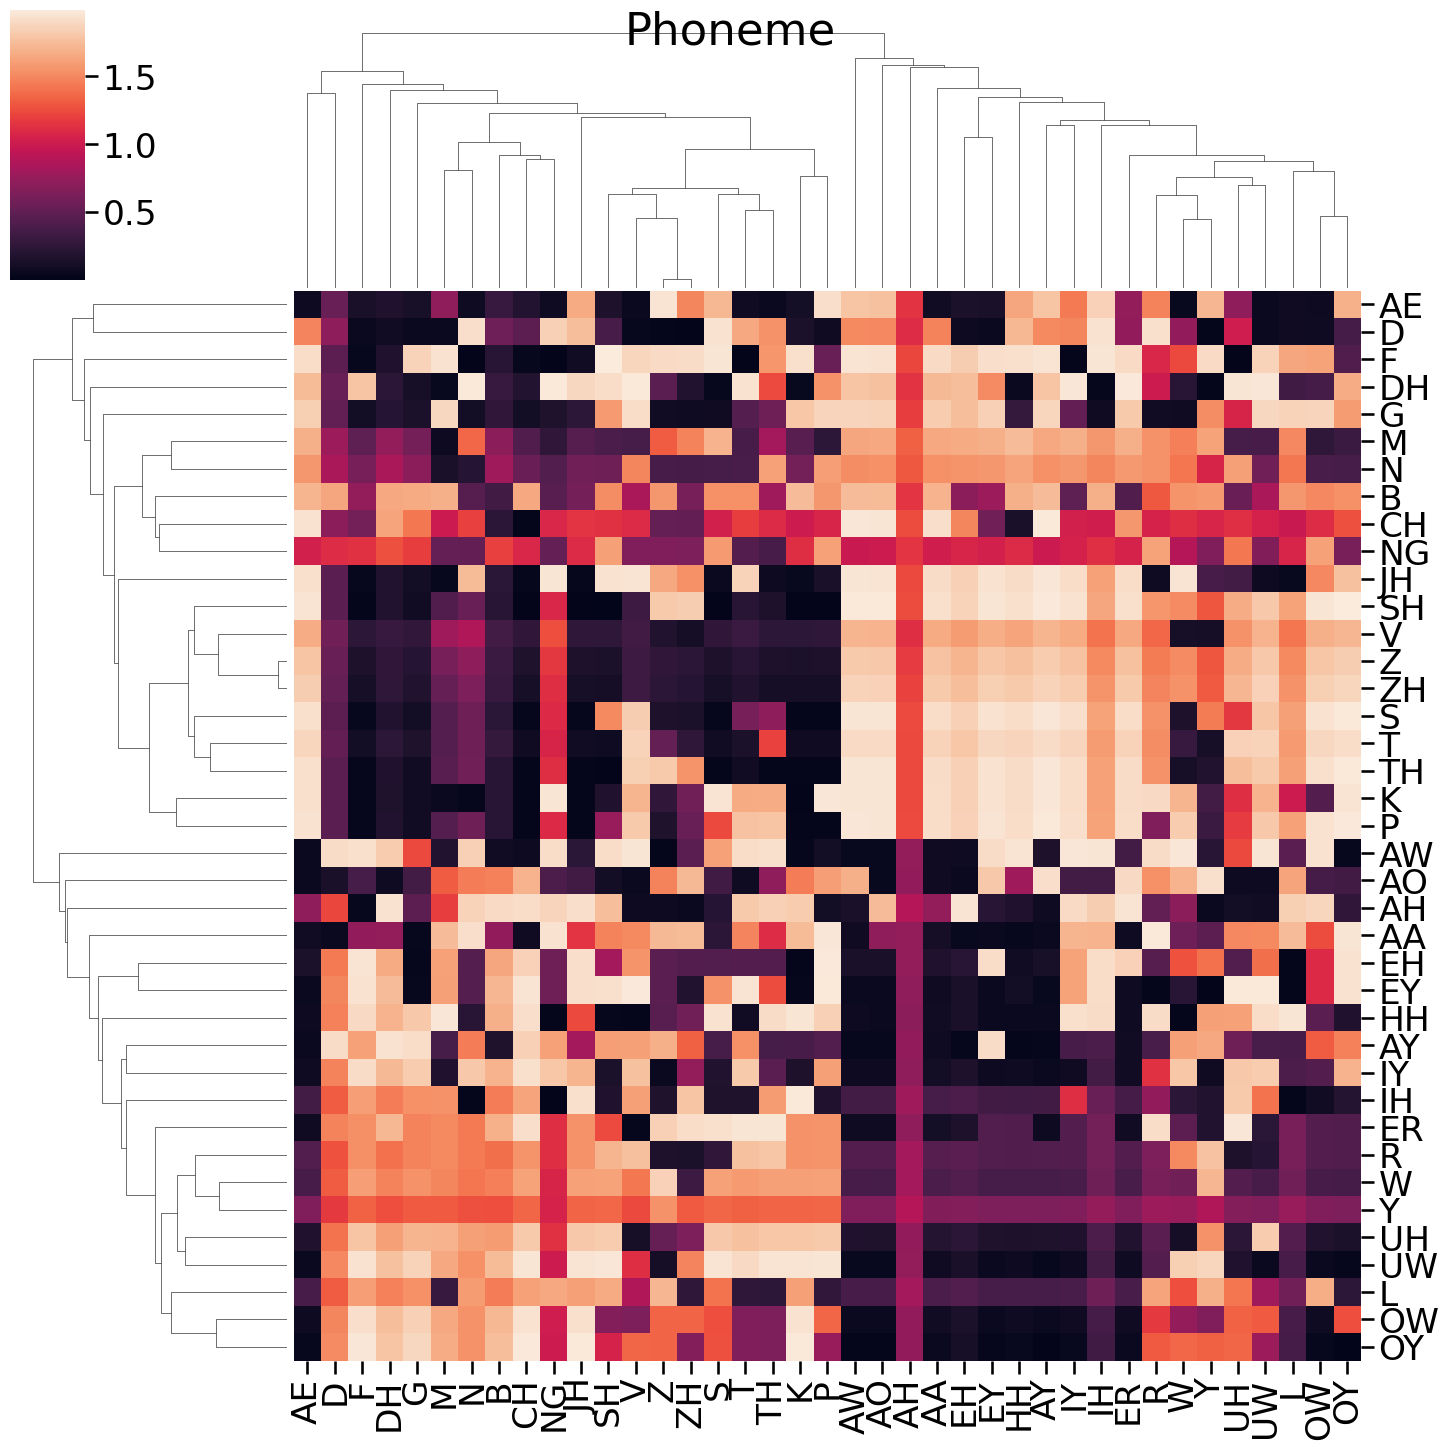

In [65]:
clustermap_model_name = "Phoneme"
clustermap_model = study_models[clustermap_model_name]
dev = rsa_mats[clustermap_model, "position", (1,)].copy()
dev[np.isnan(dev)] = 0.
dev[np.triu_indices(len(phoneme_order), 1)] = dev[np.tril_indices(len(phoneme_order), -1)]
from scipy.cluster.hierarchy import linkage
dev_linkage = linkage(dev, method="average")
g = sns.clustermap(dev, row_linkage=dev_linkage, col_linkage=dev_linkage,
                   xticklabels=phoneme_order, yticklabels=phoneme_order, figsize=(15, 15))
g.fig.suptitle(clustermap_model_name)

Text(0.5, 0.98, 'Word')

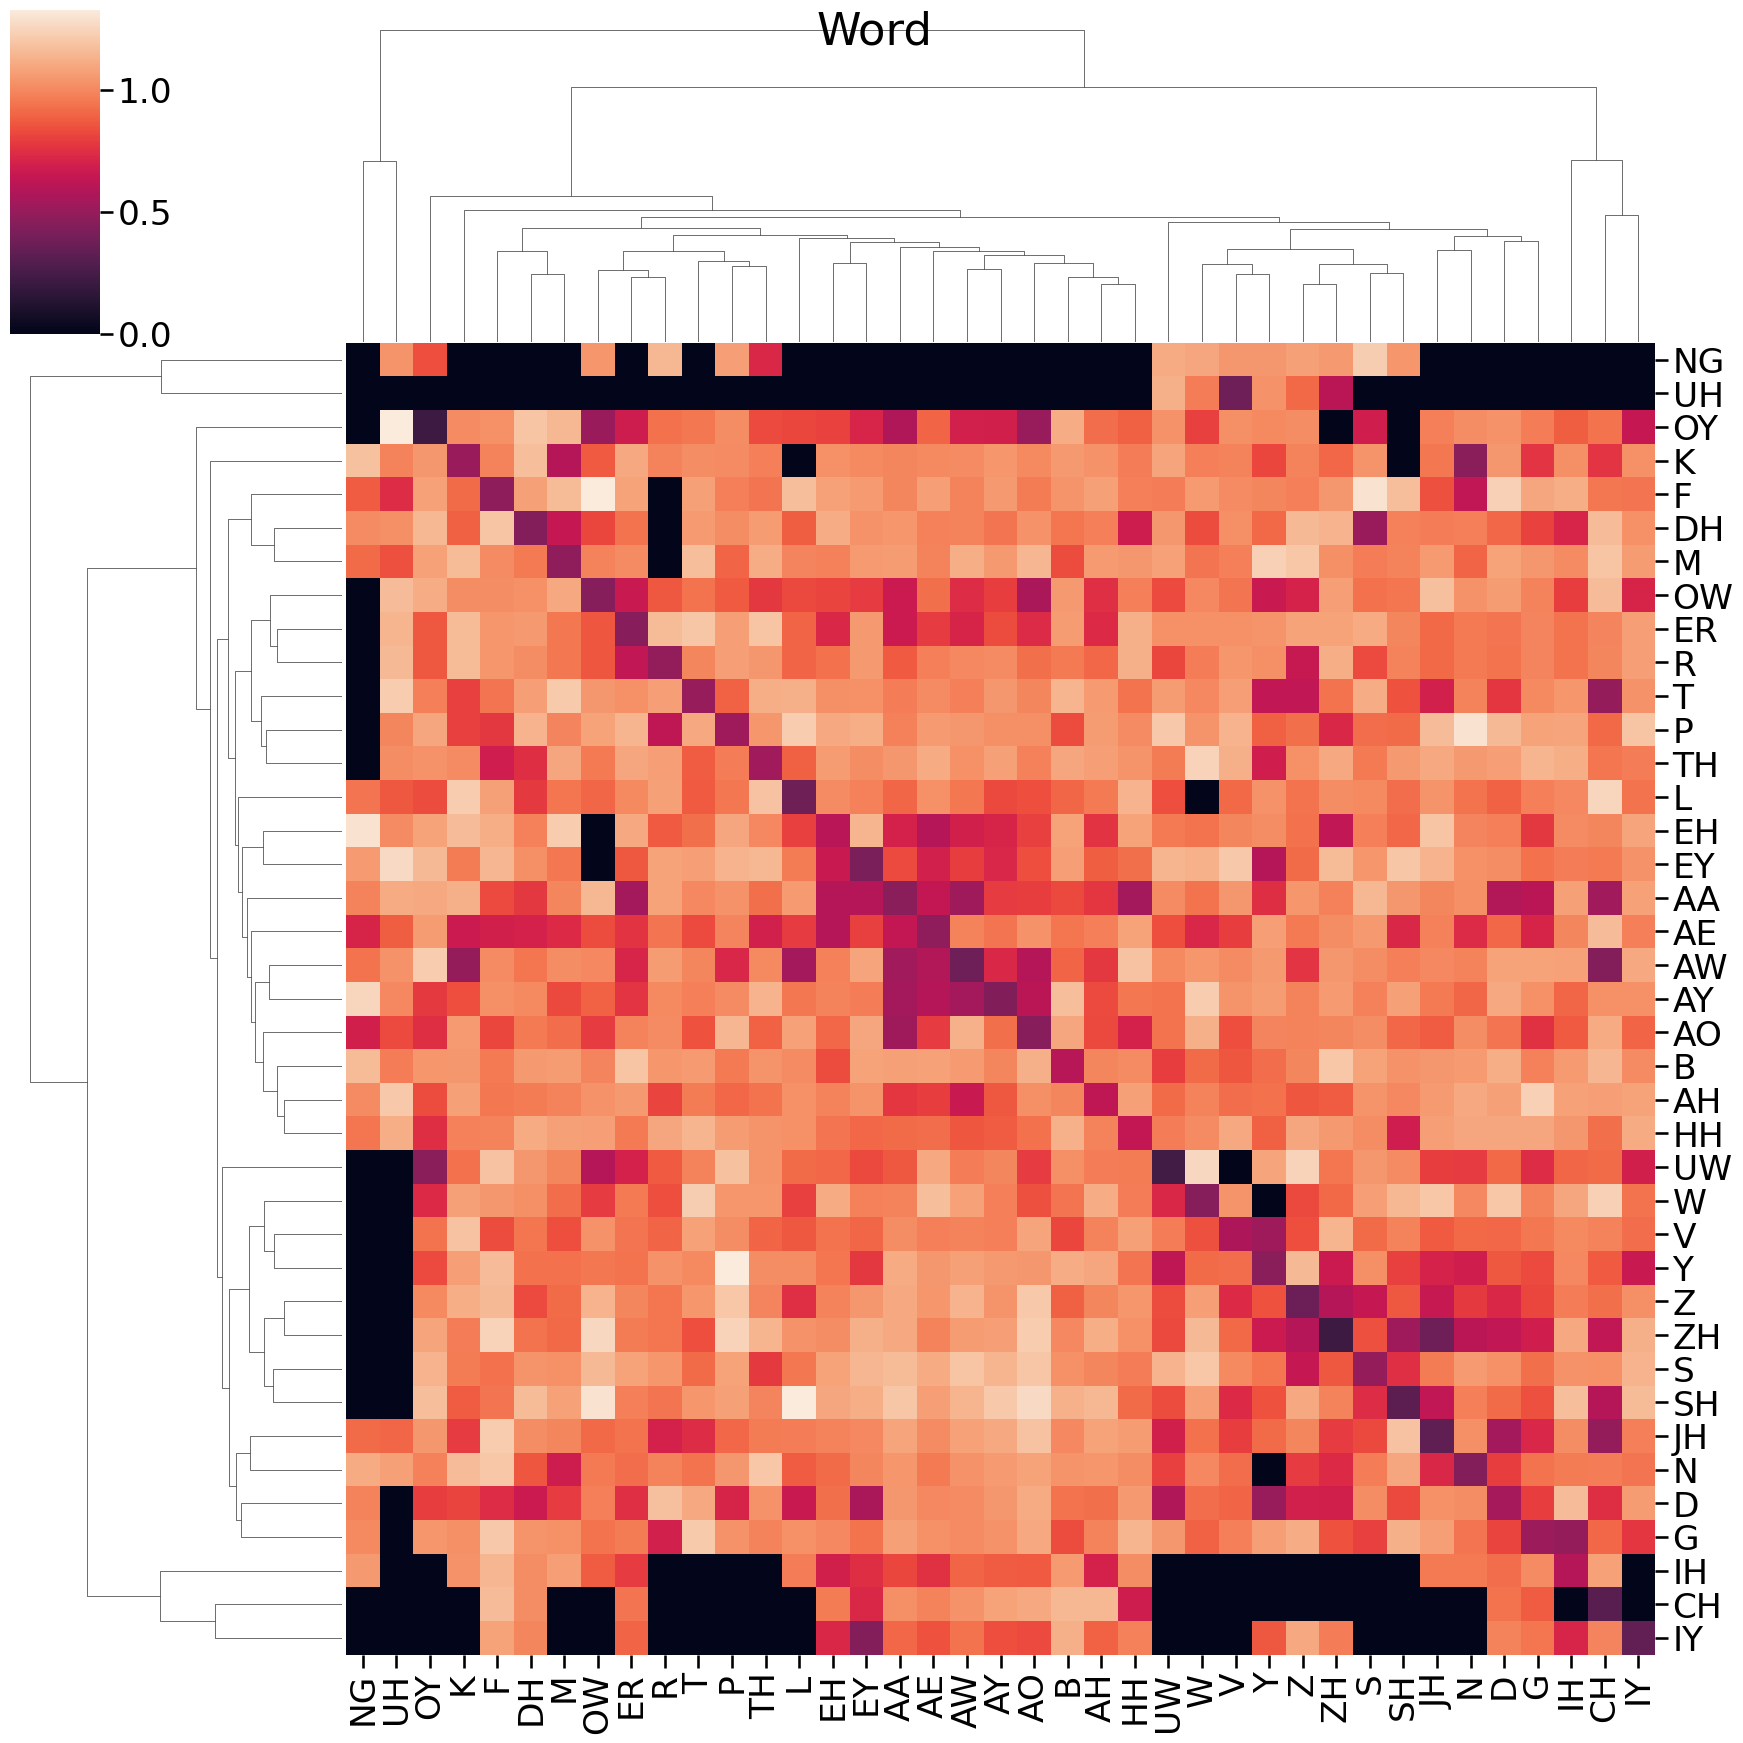

In [99]:
clustermap_model_name = "Word"
clustermap_model = study_models[clustermap_model_name]
dev = rsa_mats[clustermap_model, "position", (0,)].copy()
dev[np.isnan(dev)] = 0.
dev[np.triu_indices(len(phoneme_order), 1)] = dev[np.tril_indices(len(phoneme_order), -1)]
from scipy.cluster.hierarchy import linkage
dev_linkage = linkage(dev, method="average")
g = sns.clustermap(dev, row_linkage=dev_linkage, col_linkage=dev_linkage,
                   xticklabels=phoneme_order, yticklabels=phoneme_order, figsize=(18, 18))
g.fig.suptitle(clustermap_model_name)

## Animate sensitivity

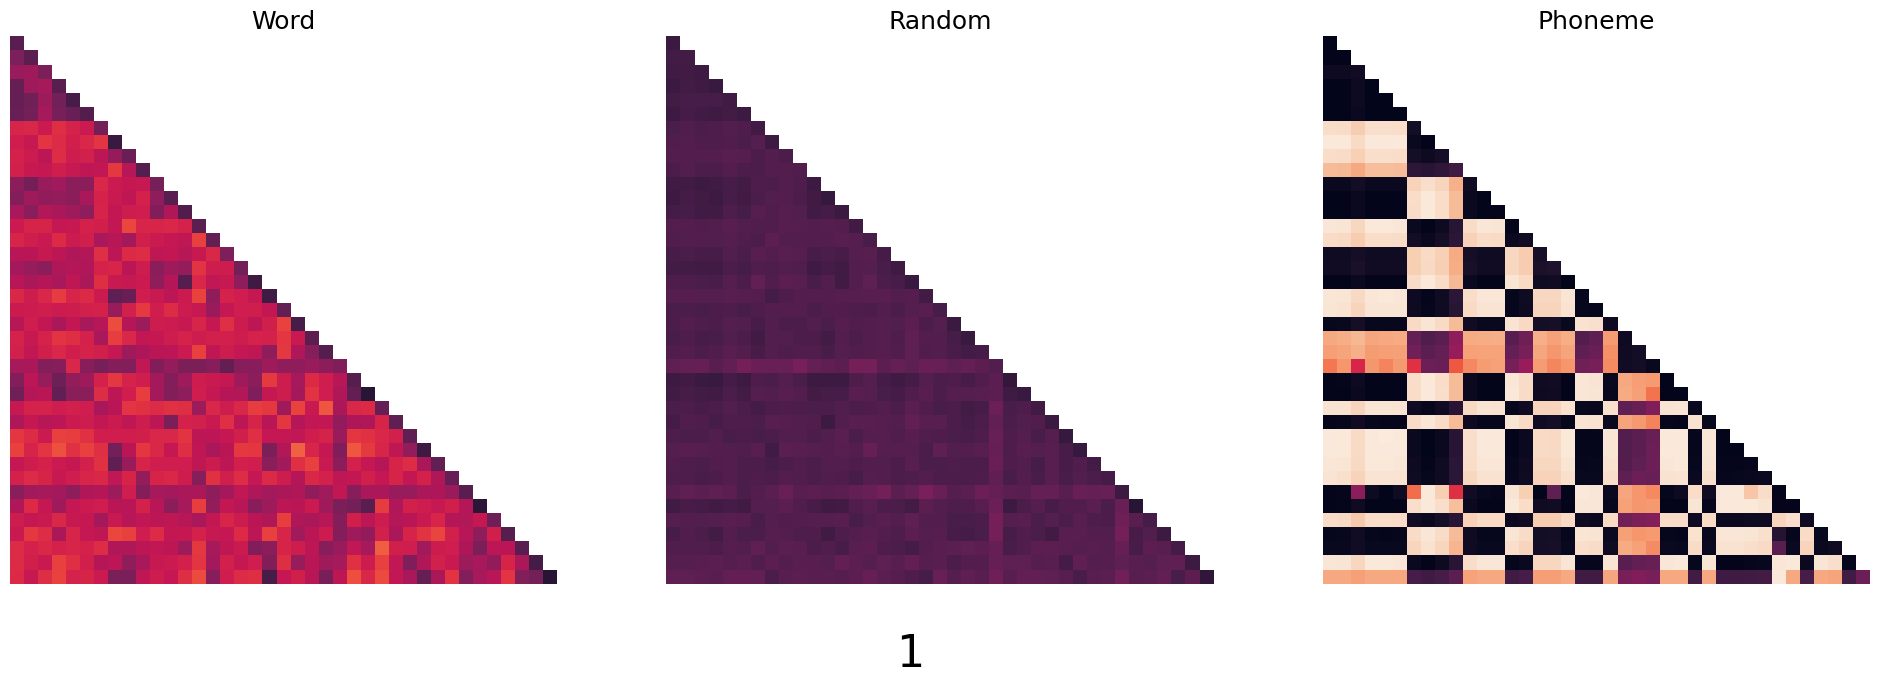

In [66]:
f, axs = plt.subplots(1, len(study_models), figsize=(8 * len(study_models), 8))
# reduce spacing
# plt.subplots_adjust(wspace=-0.25, hspace=0)
for (name, study_model), ax in zip(study_models.items(), axs.flat):
    ax.axis("off")
    ax.set_title(name, fontsize=18)
# add one text box to show current frame
text_box = f.text(0.5, 0.05, "", ha="center", fontsize=32)

def animate(i):
    frame_idx = max(0, i - pause_period)
    text_box.set_text(f"{frame_idx + 1}")
    for (name, study_model), ax in zip(study_models.items(), axs.flat):
        rsa_i = pd.DataFrame(rsa_mats[study_model, "position", (frame_idx,)],
                             index=phoneme_order, columns=phoneme_order)
        g = sns.heatmap(rsa_i, ax=ax, cbar=False, square=True,
                        xticklabels=False, yticklabels=False, vmin=0, vmax=2)

pause_period = 5
num_frames = len(set([frame_idx for _, grouper, frame_idx in rsa_mats.keys()
                      if grouper == "position"]))
num_frames = pause_period + 9
ani = anim.FuncAnimation(f, animate, frames=num_frames, interval=500)
ani.save("summary_notebooks/rsa_phoneme.gif", writer="imagemagick")